In [1]:
# Imports
import numpy as np
import pandas as pd
import dateparser
from datetime import datetime, timezone
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import HTML

In [2]:
def html(df):
    display(HTML(df.to_html(render_links=True, escape=False)))

### Matglas
De doorlooptijden van bezwaren en deelbesluiten, die op de tweede sheets in de Excel bestanden staan, worden in de plots niet gebruikt.

In [3]:
minset = pd.read_pickle('data/laatste_meting/minfinal.pkl.gz')
matglas = pd.read_pickle('data/ExcelToDF/sheetsMG.pkl.gz', compression='gzip')
traag = pd.read_pickle('data/ExcelToDF/sheetsOT.pkl.gz', compression='gzip')

In [4]:
minset.shape

(108316, 70)

In [5]:
documents = pd.read_csv('../pipe/data/WoogleDumps/woo_documents.csv.gz')
pages = pd.DataFrame(documents.groupby('foi_dossierId')['foi_nrPages'].sum()).reset_index()
pages = pages.rename(columns={'foi_nrPages':'foi_documentPages'})

merge = pd.merge(minset.reset_index(), pages, on='foi_dossierId')
minset = merge.set_index(['foi_documentId', 'foi_pageNumber'])

C:\Users\Joran\AppData\Local\Temp\ipykernel_28468\2724240289.py:1: DtypeWarning: Columns (9,10,11,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  documents = pd.read_csv('../pipe/data/WoogleDumps/woo_documents.csv.gz')


In [6]:
minset = minset[(minset['dc_type_dossier'] == '2i') &
                            (~minset.index.get_level_values(0).str.contains('bijlage')) &
                            (~minset.index.get_level_values(0).str.contains('inventaris')) &
                            (~minset.index.get_level_values(0).str.contains('verzoek'))]
minset.shape

(104115, 71)

In [7]:
matglas.rename(columns={'Ministerie':'dc_publisher_name', 
                        'Aantal dagen \nin behandeling':'looptijd_foi',
                        'Binnen de \ntermijn afgehandeld':'termijn_bool'}, inplace=True)

traag.rename(columns={'Ministerie':'dc_publisher_name', 
                      'Aantal dagen \nin behandeling':'looptijd_foi',
                      'Binnen de \ntermijn afgehandeld':'termijn_bool'}, inplace=True)

matglas['termijn_bool'].replace(['Nee', 'nee'], False, inplace=True)
matglas['termijn_bool'].replace('Ja', True, inplace=True)

traag['termijn_bool'] = traag['termijn_bool'].fillna(traag['Binnen de termijn van 8 weken afgehandeld'])
traag['termijn_bool'].replace(['Nee', 'NEE'], False, inplace=True)
traag['termijn_bool'].replace(['Ja', 'JA'], True, inplace=True)

In [8]:
def rapport(date):
    if (date >= datetime.strptime('2022-01-01', '%Y-%m-%d')) and (date <= datetime.strptime('2022-12-31', '%Y-%m-%d')):
        return 'Matglas'
    elif (date >= datetime.strptime('2020-10-01', '%Y-%m-%d')) and (date <= datetime.strptime('2021-09-30', '%Y-%m-%d')):
        return 'Ondraaglijk Traag'
    elif (date >= datetime.strptime('2023-01-01', '%Y-%m-%d')) and (date <= datetime.strptime('2023-12-31', '%Y-%m-%d')):
        return '2023'
    else:
        return 'Overig'
    
def verschil_foi(row):
    dagtekening = row['foi_decisionDate']
    verzoek = row['verzoek_datum']
    if isinstance(dagtekening, datetime) and isinstance(verzoek, datetime):
        return dagtekening - verzoek
    else:
        return None
        
def td_to_days(td):
    if td != None:
        return td.days

In [9]:
minset['looptijd_foi'] = None
minset['looptijd_foi'] = minset.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)

minset['rapport'] = minset['foi_decisionDate'].apply(lambda x: rapport(x))
minset = minset[minset['rapport'] != 'Overig']

In [10]:
# remove unnecessary columns used during process
# minset = minset.drop(columns=['dagtekening_combined', 
#                        'dagtekening_extracted', 
#                        'dagtekening_spacy', 
#                        'dagtekening_spacy_sorted', 
#                        'verzoek_spacy', 
#                        'verzoek_spacy_sorted'])

In [11]:
# het limiet voor 'binnen termijn' leek in de excels op 56 dagen te staan, dat heb ik hier overgenomen

def termijn_bool(lt):
    if isinstance(lt, (int, float)):
        if lt <= 56:
            return True
        else:
            return False
    else:
        return None

## Missing df
In dit DataFrame staat hoeveel datums missen, en aan welke datums dit vooral kan liggen.  
Als de verzoeksdatum of dagtekening mist, kan de looptijd natuurlijk niet berekend worden.  
Het komt vaak voor dat dit ligt aan een hoger aantal missende dagtekeningen.  
Sommige ministeries gebruiken voor de dagtekening een stempel, of handgeschreven datum.  
Dit is lastig te herkennen voor de Optical Character Recognition (OCR).  
De meest rechter kolom (Perc missende looptijden) laat het percentage van looptijden zien die niet berekend konden worden. 

In [12]:
def missing(df):
            
    lt_isnul = df.loc[(df.index.get_level_values(1) == 1) & (df['looptijd_foi'].isnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()
    lt_nietnul = df.loc[(df.index.get_level_values(1) == 1) & (df['looptijd_foi'].notnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()
    lt_totaal = df.loc[(df.index.get_level_values(1) == 1)].groupby('dc_publisher_name')['dc_publisher_name'].count()
    
    dt_isnul = df.loc[(df.index.get_level_values(1) == 1) & (df['foi_decisionDate'].isnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()
    dt_nietnul = df.loc[(df.index.get_level_values(1) == 1) & (df['foi_decisionDate'].notnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()
    
    vd_isnul = df.loc[(df.index.get_level_values(1) == 1) & (df['verzoek_datum'].isnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()
    vd_nietnul = df.loc[(df.index.get_level_values(1) == 1) & (df['verzoek_datum'].notnull())].groupby('dc_publisher_name')['dc_publisher_name'].count()

    missingdf= pd.DataFrame(lt_totaal).rename(columns={'dc_publisher_name':'Totaal aantal besluiten'})
    missingdf['Missende doorlooptijden'] = lt_isnul
    missingdf['Missende dagtekeningen'] = dt_isnul
    missingdf['Missende verzoeksdatums'] = vd_isnul
    
#     missingdf['Opgehaalde dagtekeningen'] = dt_nietnul
#     missingdf['Opgehaalde verzoeksdatums'] = vd_nietnul
    missingdf['Opgehaalde doorlooptijden'] = lt_nietnul
    
    missingdf['Perc missende doorlooptijden'] = (lt_isnul * 100 / lt_totaal).round(2)   

    return missingdf.fillna(0)[['Missende dagtekeningen', 
                                'Missende verzoeksdatums', 
                                'Missende doorlooptijden',
                                'Opgehaalde doorlooptijden', 
                                'Totaal aantal besluiten', 
                                'Perc missende doorlooptijden']]

display(missing(minset[minset['rapport'] == '2023']))
display(missing(minset[minset['rapport'] == 'Matglas']))
display(missing(minset[minset['rapport'] == 'Ondraaglijk Traag']))

,Missende dagtekeningen,Missende verzoeksdatums,Missende doorlooptijden,Opgehaalde doorlooptijden,Totaal aantal besluiten,Perc missende doorlooptijden
dc_publisher_name,,,,,,
Ministerie Van Algemene Zaken,0.0,0.0,0.0,54,54,0.00
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,0.0,2.0,2.0,86,88,2.27
Ministerie Van Buitenlandse Zaken,0.0,1.0,1.0,59,60,1.67
Ministerie Van Defensie,0.0,6.0,6.0,45,51,11.76
Ministerie Van Economische Zaken En Klimaat,0.0,4.0,4.0,111,115,3.48
Ministerie Van Financiën,0.0,5.0,5.0,202,207,2.42
Ministerie Van Infrastructuur En Waterstaat,0.0,17.0,17.0,166,183,9.29
Ministerie Van Justitie En Veiligheid,0.0,11.0,11.0,160,171,6.43
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",0.0,14.0,14.0,311,325,4.31


,Missende dagtekeningen,Missende verzoeksdatums,Missende doorlooptijden,Opgehaalde doorlooptijden,Totaal aantal besluiten,Perc missende doorlooptijden
dc_publisher_name,,,,,,
Ministerie Van Algemene Zaken,0.0,0.0,0.0,24,24,0.00
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,0.0,7.0,7.0,91,98,7.14
Ministerie Van Buitenlandse Zaken,0.0,7.0,7.0,74,81,8.64
Ministerie Van Defensie,0.0,3.0,3.0,58,61,4.92
Ministerie Van Economische Zaken En Klimaat,0.0,5.0,5.0,90,95,5.26
Ministerie Van Financiën,0.0,6.0,6.0,142,148,4.05
Ministerie Van Infrastructuur En Waterstaat,0.0,6.0,6.0,136,142,4.23
Ministerie Van Justitie En Veiligheid,0.0,13.0,13.0,135,148,8.78
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",0.0,9.0,9.0,258,267,3.37


,Missende dagtekeningen,Missende verzoeksdatums,Missende doorlooptijden,Opgehaalde doorlooptijden,Totaal aantal besluiten,Perc missende doorlooptijden
dc_publisher_name,,,,,,
Ministerie Van Algemene Zaken,0.0,1.0,1.0,36,37,2.70
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,0.0,3.0,3.0,74,77,3.90
Ministerie Van Buitenlandse Zaken,0.0,1.0,1.0,53,54,1.85
Ministerie Van Defensie,0.0,3.0,3.0,32,35,8.57
Ministerie Van Economische Zaken En Klimaat,0.0,9.0,9.0,105,114,7.89
Ministerie Van Financiën,0.0,2.0,2.0,117,119,1.68
Ministerie Van Infrastructuur En Waterstaat,0.0,1.0,1.0,102,103,0.97
Ministerie Van Justitie En Veiligheid,0.0,7.0,7.0,99,106,6.60
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",0.0,6.0,6.0,240,246,2.44


In [13]:
minset['verdaagd_bool'] = minset.apply(lambda x: True if x['verdaagd_context'] != None else False, axis=1)
minset['deelbesluit_bool'] = minset.apply(lambda x: True if x['deelbesluit_context'] != None else False, axis=1)
minset['termijn_bool'] = minset['looptijd'].apply(lambda x: termijn_bool(x))

minset['besluit_maand'] = minset['foi_decisionDate'].apply(lambda x: x.month if x != None and type(x) != str else None)
minset['verzoek_maand'] = minset['verzoek_datum'].apply(lambda x: x.month if x != None and type(x) != str else None)

In [14]:
plotframe = minset.loc[(minset.index.get_level_values(1) == 1)]

bad = ['Ministerie Van Algemene Zaken',
       'Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties',
       'Ministerie Van Defensie', 
       'Ministerie Van Buitenlandse Zaken']

good = ['Ministerie Van Financiën',
        'Ministerie Van Sociale Zaken En Werkgelegenheid',
        'Ministerie Van Economische Zaken En Klimaat', 
        'Ministerie Van Landbouw, Natuur En Voedselkwaliteit']

same = ['Ministerie Van Onderwijs, Cultuur En Wetenschap',
        'Ministerie Van Infrastructuur En Waterstaat',
        'Ministerie Van Justitie En Veiligheid',
        'Ministerie Van Volksgezondheid, Welzijn En Sport',]

bad_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == bad[0]) | 
                          (plotframe['dc_publisher_name'] == bad[1]) | 
                          (plotframe['dc_publisher_name'] == bad[2]) | 
                          (plotframe['dc_publisher_name'] == bad[3])]

same_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == same[0]) | 
                          (plotframe['dc_publisher_name'] == same[1]) | 
                          (plotframe['dc_publisher_name'] == same[2]) | 
                          (plotframe['dc_publisher_name'] == same[3])]

good_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == good[0]) | 
                          (plotframe['dc_publisher_name'] == good[1]) | 
                          (plotframe['dc_publisher_name'] == good[2]) | 
                          (plotframe['dc_publisher_name'] == good[3])]

plotframes = [bad_plotframe, same_plotframe, good_plotframe]

# Fracties type besluit per ministerie

In elk document is gekeken of er een duidelijk kopje met 'Besluit' was. Dit is eruitgehaald en geclassificeerd met een machine learning model getrained voor specifiek deze data. De gebruikte library is Spacy.  
Het model is getrained door in totaal 900 van deze zinnen uit 2022 en 2023 handmatig te classificeren.  
Omdat bijvoorbeeld volledig openbare besluiten weinig voorkwamen, zijn dit soort besluiten handmatig uitgezocht om het model deze besluiten beter te leren herkennen.  

Een **openbaar** besluit werd pas toegekend als het besluit 'volledig openbaar' was, en er geen persoonsgegevens zijn weggehaald.  
Een **deels openbaar** besluit werd toegekend als het 'deels openbaar' is, of als het volledig openbaar was, maar er persoonsgegevens zijn weggehaald.  
Een **afgewezen** besluit is toegekend als het besluit is afgewezen, of als de informatie al openbaar is gemaakt.  
Een **niet aanwezig** besluit is toegekend als de informatie niet bij het ministerie berustte.  

Een ongegrond bezwaar werd gezien als 'afgewezen', en een gegrond bezwaar als 'openbaar' of 'deels openbaar', liggend aan het hernieuwde besluit welke er achter staat.  


De dataset waarop getrained is had uiteindelijk deze verhoudingen:  
deels openbaar: 293  
niet aanwezig: 237  
afgewezen: 190  
openbaar: 180  

Grotere steekproef volgt nog.  

<Figure size 640x480 with 0 Axes>

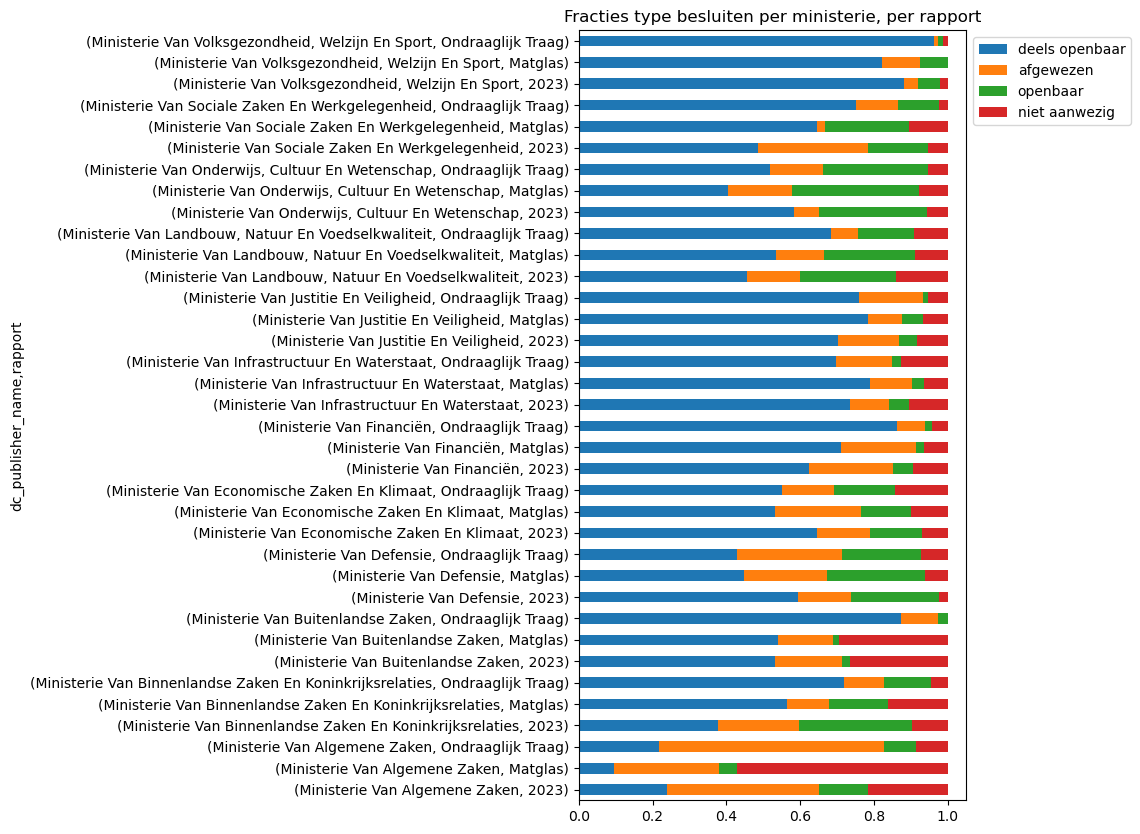

In [15]:
plt.figure()

df = plotframe.copy()

grouped_st = df.groupby(['dc_publisher_name', 'rapport'])['besluit_type'].value_counts().reset_index()
totals_st = df.groupby(['dc_publisher_name', 'rapport'])['besluit_type'].value_counts().groupby(['dc_publisher_name', 'rapport']).sum()
indivi_st = df.groupby(['dc_publisher_name', 'rapport'])['besluit_type'].value_counts()
besluit_perc_st = (indivi_st/totals_st).reset_index()

pivot = pd.pivot_table(besluit_perc_st, values='count', index=['dc_publisher_name', 'rapport'], columns='besluit_type')
pivot = pivot[['deels openbaar', 'afgewezen', 'openbaar', 'niet aanwezig']]

pivot.plot.barh(stacked=True, figsize=(5, 10), use_index=True)
plt.title('Fracties type besluiten per ministerie, per rapport')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
plt.close('all')

# for ministerie in set(pivot.index.get_level_values(0)):
#     pivot[pivot.index.get_level_values(0) == ministerie].plot.barh(stacked=True, figsize=(5, 10))

In [16]:
def plot_besluiten(name, df):
    plt.figure()
    
    grouped = df.groupby('dc_publisher_name')['besluit_type'].value_counts().reset_index()
    totals = df.groupby('dc_publisher_name')['besluit_type'].value_counts().groupby('dc_publisher_name').sum()
    indivi = df.groupby('dc_publisher_name')['besluit_type'].value_counts()
    besluit_perc = (indivi/totals).reset_index()

    fig, besluit_plot = plt.subplots(figsize=(5,10))

    besluit_fig = sns.barplot(data=besluit_perc, y='dc_publisher_name', x='count', hue='besluit_type', ax=besluit_plot)
    besluit_fig.set(ylabel='Ministerie', xlabel='Fractie besluiten')
    besluit_fig.set_title(f"Fractie soort besluiten in het rapport {name}")

    sns.move_legend(besluit_fig, "upper left", bbox_to_anchor=(1, 1))

    besluit_fig.bar_label(besluit_fig.containers[0], fmt='%0.2f')
    besluit_fig.bar_label(besluit_fig.containers[1], fmt='%0.2f')
    besluit_fig.bar_label(besluit_fig.containers[2], fmt='%0.2f')
    besluit_fig.bar_label(besluit_fig.containers[3], fmt='%0.2f')
    
    plt.savefig(f"data/plots/besluit/perc_besluiten_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    
# for frame in plotframe.groupby('rapport'):
#     plot_besluiten(frame[0], frame[1])

# Fractie verdaagd per ministerie, per jaar

In deze grafiek is te zien in hoeveel documenten er gesproken is over een verdaging.  
Als in een document het woord 'verdaag' is gevallen, telt dit als een 'verdaging' en wordt het gemarkeerd als 'verdaagd'.  
Het wordt per heel document berekend, dus een document met 10 pagina's telt dus niet 10 keer mee. 

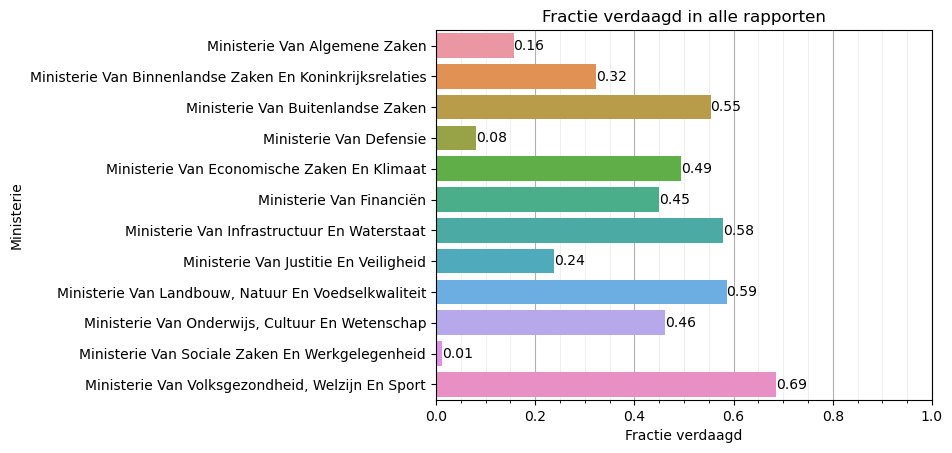

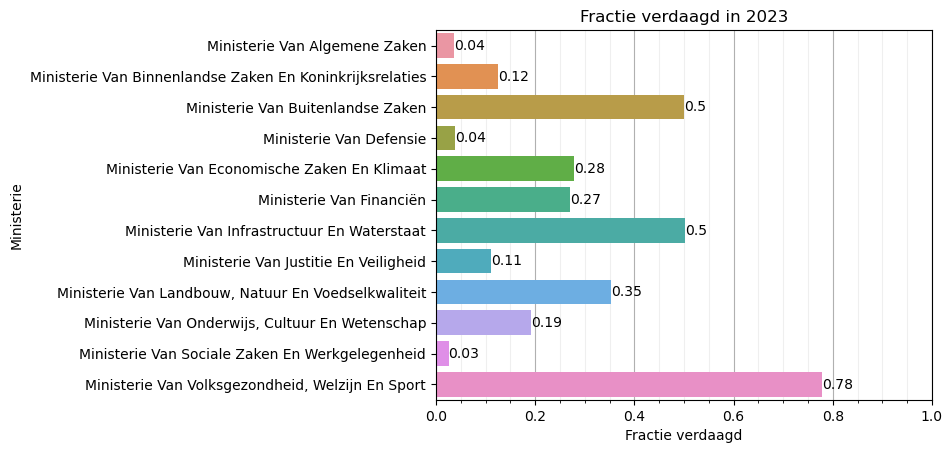

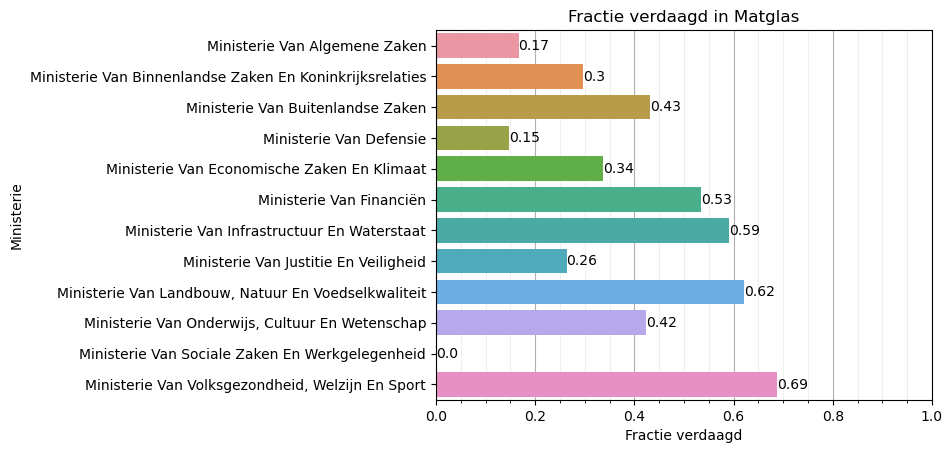

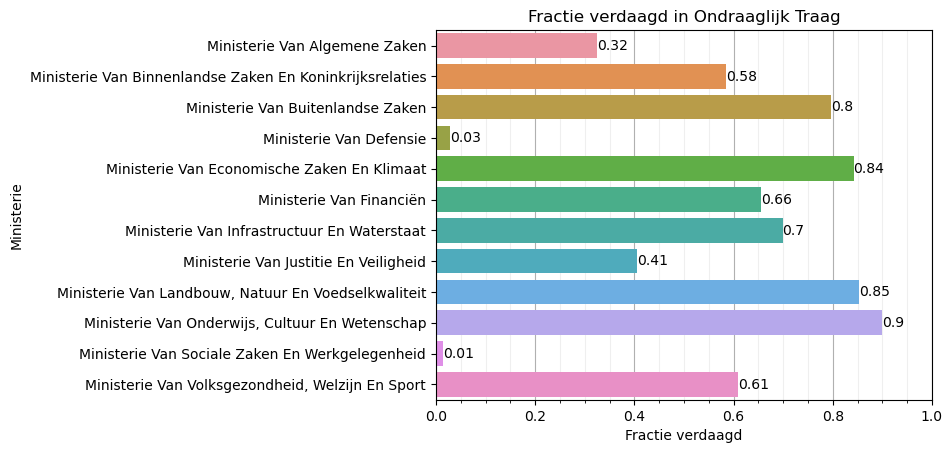

In [17]:
def plot_verdaagd(name, df):
    plt.figure()
    summ = df.groupby('dc_publisher_name')['verdaagd_bool'].agg('sum')
    total = df.groupby('dc_publisher_name')['verdaagd_bool'].agg('count')

    verdaagd_perc = summ / total
    order = sorted(df['dc_publisher_name'].unique())
    verdaagd_plot = sns.barplot(df, x='verdaagd_bool', y='dc_publisher_name', order=order, errorbar=None)

    verdaagd_plot.set_xlim(0, 1)

    verdaagd_plot.yaxis.grid(False)
    verdaagd_plot.xaxis.grid(True)
    verdaagd_plot.grid(which='minor', alpha=0.2)
    verdaagd_plot.set_axisbelow(True)

    verdaagd_plot.xaxis.set_minor_locator(MultipleLocator(0.05))
    verdaagd_plot.xaxis.set_major_locator(MultipleLocator(0.2))
    verdaagd_plot.set(ylabel='Ministerie', xlabel='Fractie verdaagd')
    verdaagd_plot.bar_label(verdaagd_plot.containers[0], labels=verdaagd_perc.round(2))
    verdaagd_plot.set_title(f"Fractie verdaagd in {name}")\
    
#     plt.savefig(f"data/plots/verdaagd/perc_verdaagd_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    
plot_verdaagd('alle rapporten', plotframe)
    
for frame in plotframe.groupby('rapport'):
    plot_verdaagd(frame[0], frame[1])

# Fractie deelbesluiten per ministerie, per jaar

Deze grafiek laat zien hoeveel documenten het hadden over een deelbesluit.  
Als er wordt gesproken over 'deelbesluit' wordt het document gemarkeerd als deelbesluit.  
Het wordt per heel document berekend, dus een document met 10 pagina's telt dus niet 10 keer mee. 

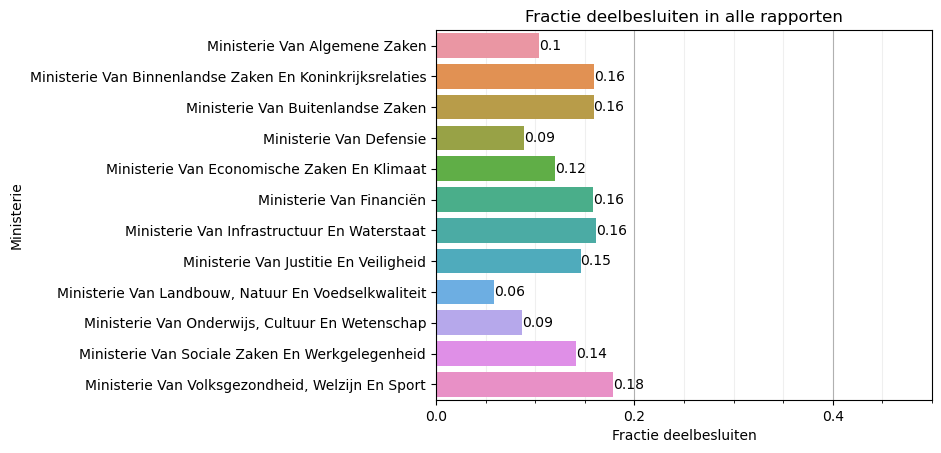

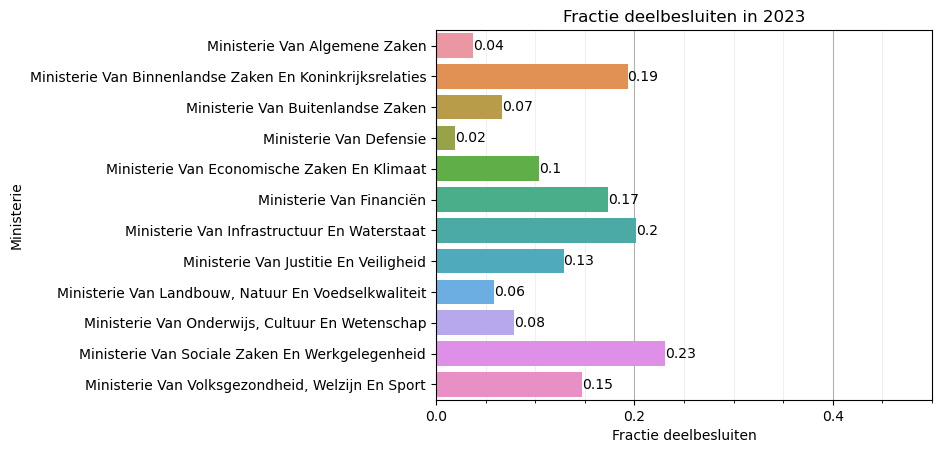

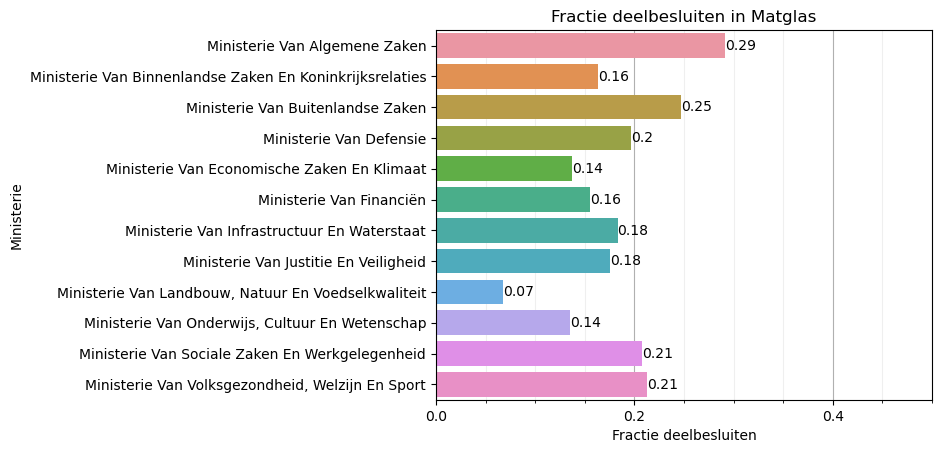

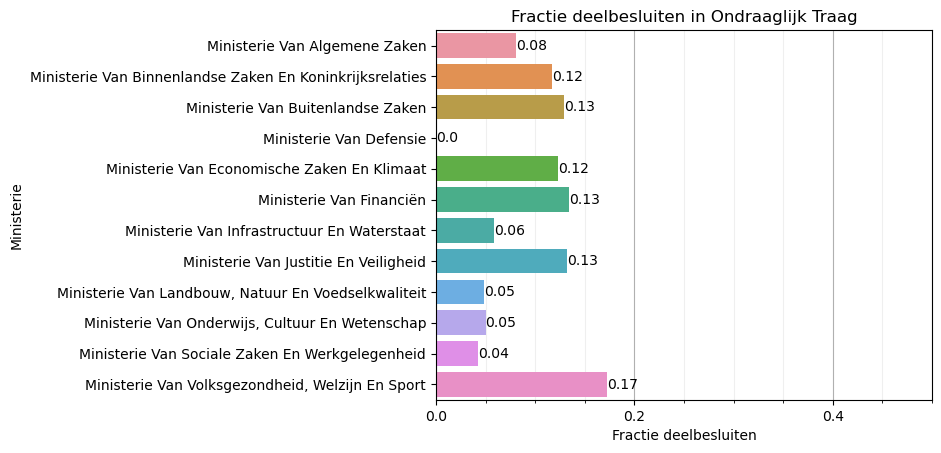

In [18]:
def plot_deelbesluit(name, df):    
    plt.figure()

    summ = df.groupby('dc_publisher_name')['deelbesluit_bool'].agg('sum')
    total = df.groupby('dc_publisher_name')['deelbesluit_bool'].agg('count')

    deelbesluit_perc = summ / total

    order = sorted(df['dc_publisher_name'].unique())
    deelbesluit_plot = sns.barplot(df, x='deelbesluit_bool', y='dc_publisher_name', order=order, errorbar=None)

    deelbesluit_plot.set_xlim(0, 0.5)

    deelbesluit_plot.yaxis.grid(False)
    deelbesluit_plot.xaxis.grid(True)
    deelbesluit_plot.grid(which='minor', alpha=0.2)
    deelbesluit_plot.set_axisbelow(True)

    deelbesluit_plot.xaxis.set_minor_locator(MultipleLocator(0.05))
    deelbesluit_plot.xaxis.set_major_locator(MultipleLocator(0.2))
    deelbesluit_plot.set(ylabel='Ministerie', xlabel='Fractie deelbesluiten')
    deelbesluit_plot.bar_label(deelbesluit_plot.containers[0], labels=deelbesluit_perc.round(2))
    deelbesluit_plot.set_title(f"Fractie deelbesluiten in {name}")
    
#     plt.savefig(f"data/plots/deelbesluit/perc_deelbesluit_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    
plot_deelbesluit('alle rapporten', plotframe)
    
for frame in plotframe.groupby('rapport'):
    plot_deelbesluit(frame[0], frame[1])

# Wanneer worden de meeste besluiten genomen?

Als er een dagtekening beschikbaar is, wordt hier de maand van genomen.  
Deze maanden worden gegroepeerd, en per maand wordt berekend hoeveel van deze besluiten in die maand vielen.  
Het wordt per heel document berekend, dus een document met 10 pagina's telt dus niet 10 keer mee. 

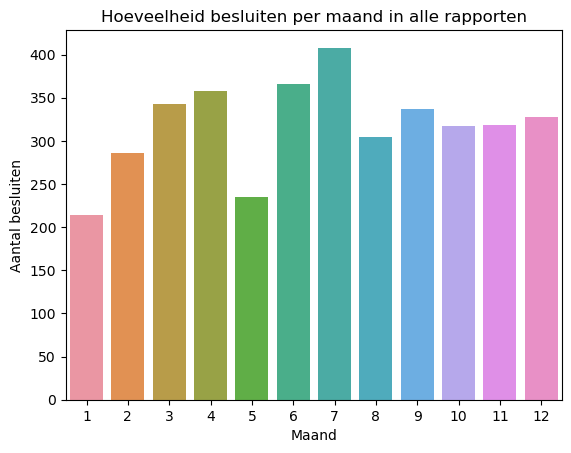

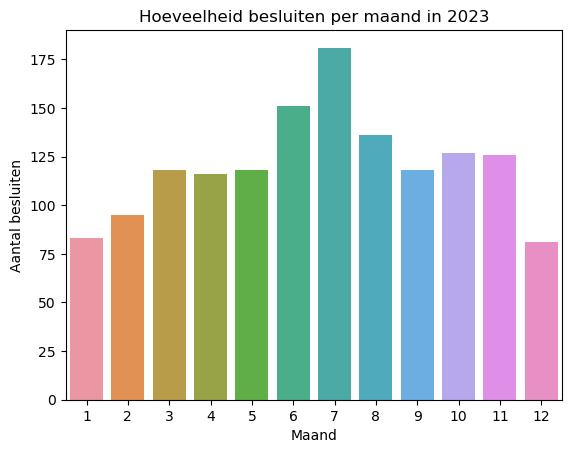

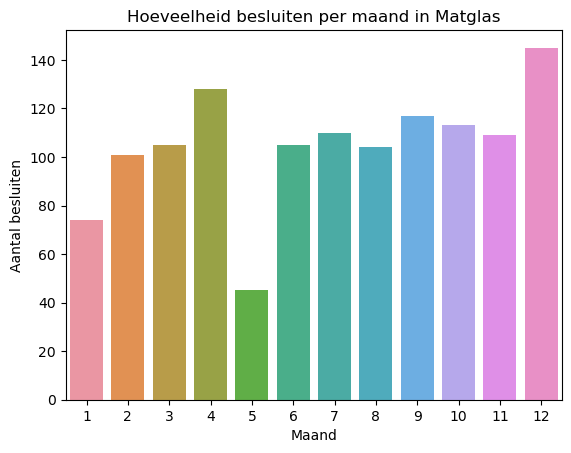

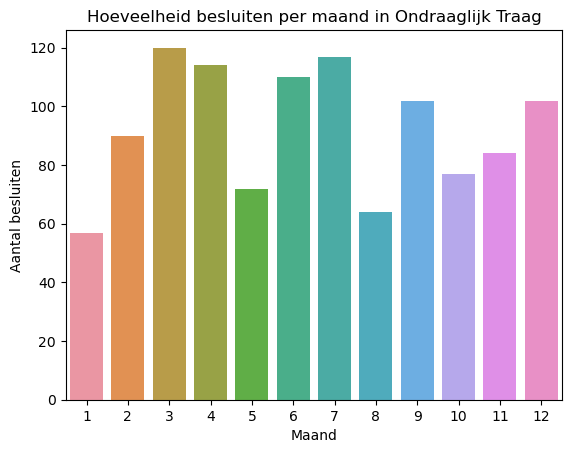

In [19]:
def wanneer_besluit(name, df):
    plt.figure()
    wanneer_plot = sns.countplot(df[df.index.get_level_values(1) == 1], x='besluit_maand')
    wanneer_plot.set(xlabel='Maand', ylabel='Aantal besluiten')
    wanneer_plot.set_title(f"Hoeveelheid besluiten per maand in {name}")
    
#     plt.savefig(f"data/plots/wanneer_besluit/wanneer_besluiten_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')

wanneer_besluit('alle rapporten', plotframe)
    
for frame in minset.groupby('rapport'):
    wanneer_besluit(frame[0], frame[1])

# Wanneer worden de meeste verzoeken ingediend?


Als er een verzoeksdatum beschikbaar is, wordt hier de maand van genomen.  
Deze maanden worden gegroepeerd, en per maand wordt berekend hoeveel van deze verzoeken in die maand vielen.  
Het wordt per heel document berekend, dus een document met 10 pagina's telt dus niet 10 keer mee. 

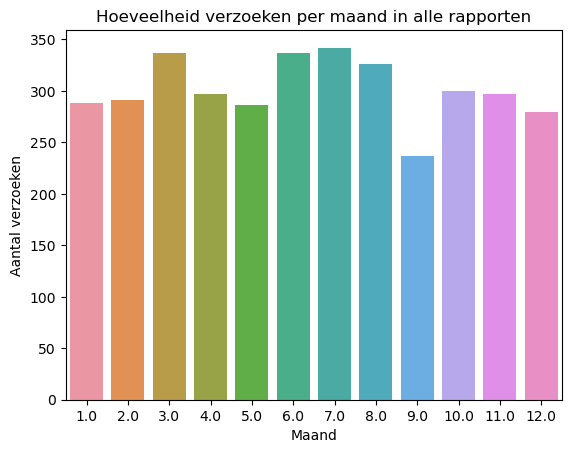

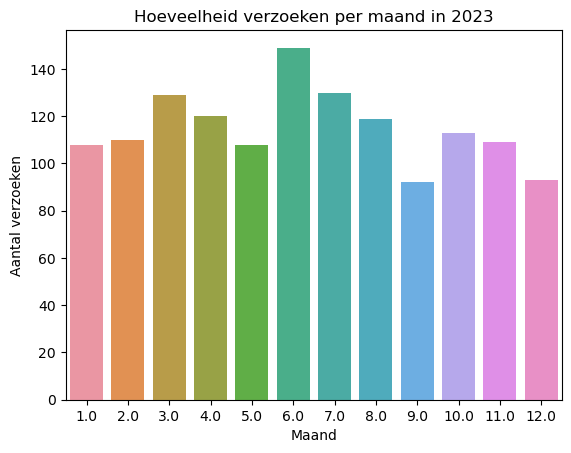

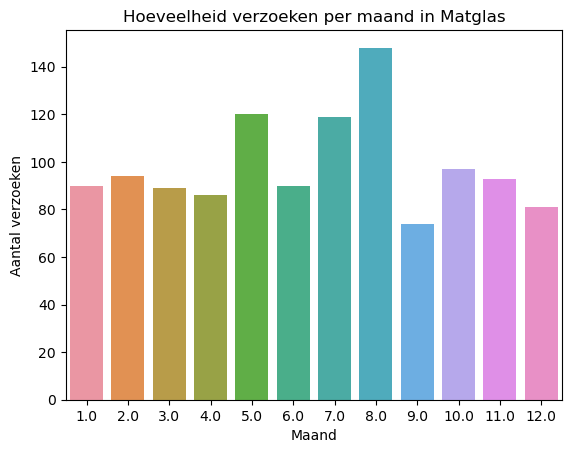

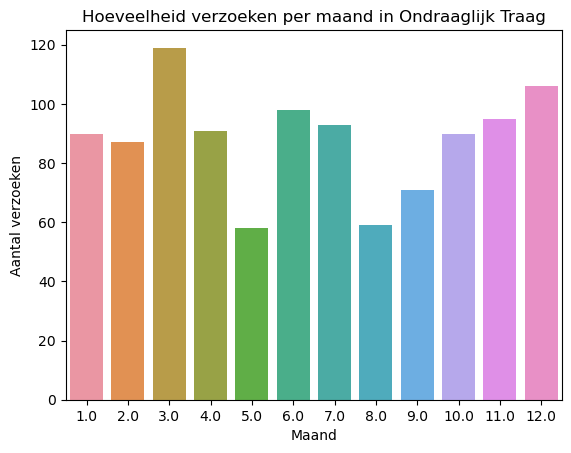

In [20]:
def wanneer_verzoek(name, df):
    plt.figure()
    wanneer_plot = sns.countplot(df[df.index.get_level_values(1) == 1], x='verzoek_maand')
    wanneer_plot.set(xlabel='Maand', ylabel='Aantal verzoeken')
    wanneer_plot.set_title(f"Hoeveelheid verzoeken per maand in {name}")
    
#     plt.savefig(f"data/plots/wanneer_verzoek/wanneer_verzoek_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')

wanneer_verzoek('alle rapporten', plotframe)
    
for frame in minset.groupby('rapport'):
    wanneer_verzoek(frame[0], frame[1])

# Aandeel binnen termijn behandeld

Als er een looptijd beschikbaar is, wordt gekeken of deze looptijd lager of gelijk is aan 56 dagen.  
Is dit het geval? Dan krijgt dit document een 'True', hij is dan binnen de termijn behandeld.  
Per ministerie wordt dan opgeteld hoeveel van deze looptijden binnen de tijd zijn behandeld, en er wordt gekeken naar hoeveel looptijden er opgehaald konden worden. Als een dagtekening of verzoeksdatum miste, kon geen looptijd berekend worden, en is dit document ook niet meegenomen in de berekening.  
Dus het aantal looptijden dat lager of gelijk is aan 56, wordt gedeeld door alle looptijden die berekend konden worden.  
De labels zijn afgerond op 2 cijfers achter de komma, bij de plot van 2023 staat bijvoorbeeld '0.4', maar hij raakt net de lijn niet. Dit komt door de afronding van 0.395 naar 0.4.  

Stel er zijn totaal 95 documenten, 20 zijn lager of gelijk dan 56. 50 looptijden konden berekend worden, 45 dus niet.  
Dan zijn 20 / 50 = 0.4 ofwel 40% van de documenten binnen de termijn behandeld.  

Voor de plots over Ondraaglijk Traag en Matglas is de data uit de excel bestanden gebruikt.  
Deze bestanden hebben een kolom met data waar is aangegeven of ze binnen de termijn (<= 56 dagen) zijn behandeld.  
Deze kolommen zijn van 'Ja' en 'Nee' omgevormd tot True en False, waardoor ze ook gebruikt konden worden in de berekeningen.  
Bij het Ministerie Van Defensie in de excel bestanden van Ondraaglijk Traag was zowel een kolom over of het binnen 4, of 8 weken was gehaald. Hierbij heb ik de kolom van 8 weken gebruikt.  

In [21]:
total_ms = missing((minset[(minset['rapport'] == '2023') & (minset.index.get_level_values(1) == 1)]))['Opgehaalde doorlooptijden']
total_mg = matglas[['dc_publisher_name', 'termijn_bool']].groupby('dc_publisher_name')['termijn_bool'].agg('count')
total_ot = traag[['dc_publisher_name', 'termijn_bool']].groupby('dc_publisher_name')['termijn_bool'].agg('count')

sum_ms = (minset[(minset['rapport'] == '2023') & (minset.index.get_level_values(1) == 1)]).groupby('dc_publisher_name')['termijn_bool'].agg('sum')
sum_mg = matglas[['dc_publisher_name', 'termijn_bool']].groupby('dc_publisher_name')['termijn_bool'].agg('sum')
sum_ot = traag[['dc_publisher_name', 'termijn_bool']].groupby('dc_publisher_name')['termijn_bool'].agg('sum')


total_all = total_ms + total_mg + total_ot
sum_all = sum_ms + sum_mg + sum_ot

ms_df = pd.DataFrame(sum_ms).rename(columns={'termijn_bool':'sum'})
ms_df['total'] = total_ms
ms_df['frac'] = ms_df['sum'].astype(float) / ms_df['total'].astype(float)

all_df = pd.DataFrame(sum_all).rename(columns={'termijn_bool':'sum'})
all_df['total'] = total_all
all_df['frac'] = all_df['sum'].astype(float) / all_df['total'].astype(float)

def plot_binnen_termijn(name, df):    
    plt.figure()

    order = sorted(df.index.unique())
    termijn_plot = sns.barplot(df, x='frac', y=df.index, order=order, errorbar=None)

    termijn_plot.set_xlim(0, 1)

    termijn_plot.yaxis.grid(False)
    termijn_plot.xaxis.grid(True)
    termijn_plot.grid(which='minor', alpha=0.2)
    termijn_plot.set_axisbelow(True)

    termijn_plot.xaxis.set_minor_locator(MultipleLocator(0.05))
    termijn_plot.xaxis.set_major_locator(MultipleLocator(0.2))
    termijn_plot.set(ylabel='Ministerie', xlabel='Fractie korter dan 56 dagen')
    termijn_plot.bar_label(termijn_plot.containers[0], labels=df['frac'].round(2))
    termijn_plot.set_title(f"Fractie looptijden korter dan 56 dagen in {name}")
    
#     plt.savefig(f"data/plots/termijn/perc_binnen_termijn_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    
def plot_binnen_termijn_excel(name, df):    
    plt.figure()

    summ = df.groupby('dc_publisher_name')['termijn_bool'].agg('sum')
    if name == 'Matglas' or name == 'Ondraaglijk Traag':
        total = df.groupby('dc_publisher_name')['termijn_bool'].agg('count')
    else:
        total = missing(df[df['rapport'] == name])['Opgehaalde looptijden']

    termijn_perc = summ.astype(float) / total.astype(float)

    order = sorted(df['dc_publisher_name'].unique())
    termijn_plot = sns.barplot(df, x='termijn_bool', y='dc_publisher_name', order=order, errorbar=None)

    termijn_plot.set_xlim(0, 1)

    termijn_plot.yaxis.grid(False)
    termijn_plot.xaxis.grid(True)
    termijn_plot.grid(which='minor', alpha=0.2)
    termijn_plot.set_axisbelow(True)

    termijn_plot.xaxis.set_minor_locator(MultipleLocator(0.05))
    termijn_plot.xaxis.set_major_locator(MultipleLocator(0.2))
    termijn_plot.set(ylabel='Ministerie', xlabel='Fractie korter dan 56 dagen')
    termijn_plot.bar_label(termijn_plot.containers[0], labels=termijn_perc.round(2))
    termijn_plot.set_title(f"Fractie looptijden korter dan 56 dagen in {name}")
    
#     plt.savefig(f"data/plots/termijn/perc_binnen_termijn_{name}.svg", bbox_inches='tight')
    
    plt.show()
    plt.close('all')   

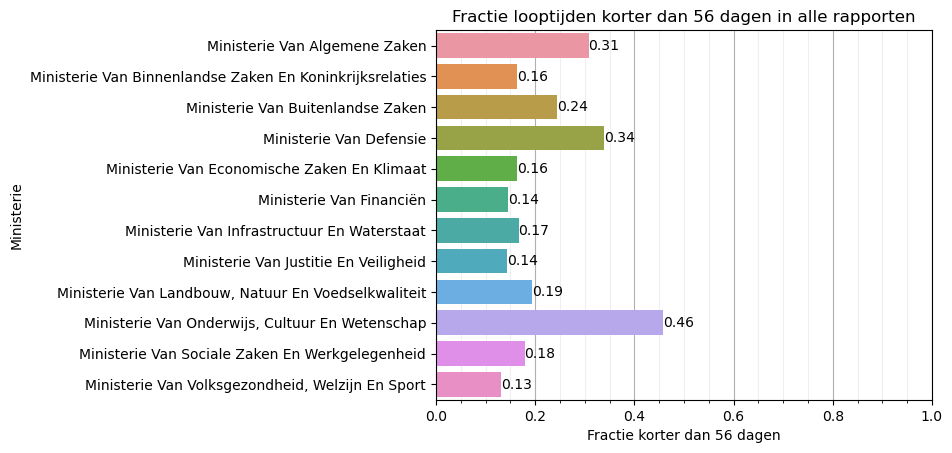

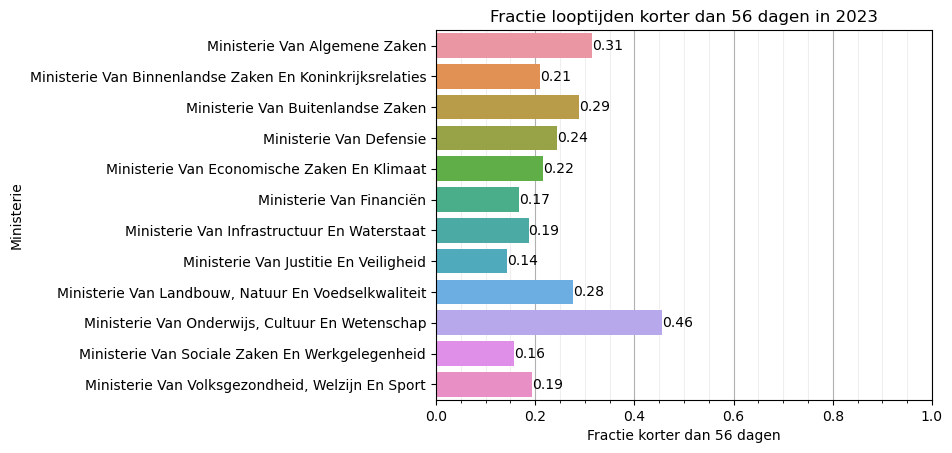

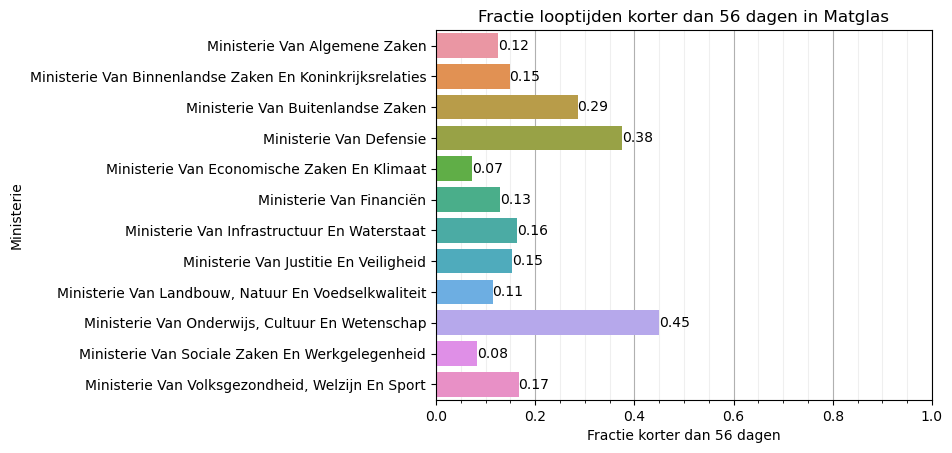

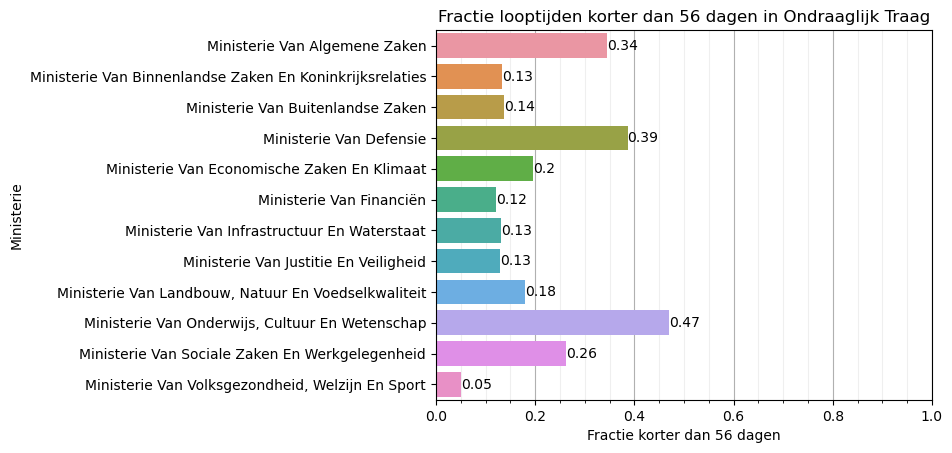

In [22]:
plot_binnen_termijn('alle rapporten', all_df)
    
plot_binnen_termijn('2023', ms_df)
        
plot_binnen_termijn_excel('Matglas', matglas)
plot_binnen_termijn_excel('Ondraaglijk Traag', traag)

## Waar gaat het mis met de missende verzoeksdatums?

Er zijn minder missende verzoeksdatums dan missende dagtekeningen (81 tegenover 210), maar hierdoor kunnen looptijden ook missen.  
Waar gaat dit fout?  

 - https://open.overheid.nl/documenten/40cd5d79-ba2c-444b-be5d-72ed861c9e9e/file
   - Het jaar mist, hierdoor wordt het gezien als incomplete datum, en wordt de datum niet opgeschreven.  
 - https://open.overheid.nl/documenten/ronl-2f3cd42f9f522db04afe483d595bf43b02661dda/pdf
   - Het extractie proces kijkt op de verkeerde plek, en kan niks vinden.
   - In dit geval werd gekeken rondom het onderwerp, waar het foutief dacht een match te hebben.
   - nl “**2-3 kat 2023** betreft besluit op uw woo-verzoek datum ons kenmerk 2022
 - https://open.overheid.nl/documenten/1a3ca6ae-bd7b-4d96-b864-25c4bc3bea65/file
   - In plaats van het jaar, wordt de afkorting '**jl.**' gebruikt, hierdoor wordt het ook gezien als incomplete datum.
 - https://open.overheid.nl/documenten/ronl-7ec7e919ab4e276e143cd77591d38de66b174906/pdf
   - OCR foutjes (geachte u heeft per e-mail van 1 **jufi** 2022). 'jufi' kan niet worden gelezen als juli

In [23]:
ms_dt = missing(minset[minset['rapport'] == '2023'])['Missende dagtekeningen'].sum()
ms_vz = missing(minset[minset['rapport'] == '2023'])['Missende verzoeksdatums'].sum()

print(f"Missende dagtekeningen: {ms_dt}")
print(f"Missende verzoeksdatums: {int(ms_vz)}")

Missende dagtekeningen: 0.0
Missende verzoeksdatums: 70


In [24]:
minset.columns

Index(['foi_dossierType', 'foi_bodyText', 'foi_bodyTextOCR', 'foi_hasOCR',
       'foi_redacted', 'foi_nrRedactedRegions', 'foi_contourArea',
       'foi_textArea', 'foi_charArea', 'foi_percentageTextAreaRedacted',
       'foi_percentageCharAreaRedacted', 'foi_imageArea',
       'foi_imageCoversFullPage', 'foi_bodyTextJaccard', 'foi_dossierId',
       'dc_title', 'dc_description', 'foi_fileName', 'dc_format', 'dc_source',
       'dc_type', 'foi_nrPages', 'foi_pdfDateCreated', 'foi_pdfDateModified',
       'foi_pdfCreator', 'foi_pdfProducer', 'foi_pdfAuthor', 'foi_pdfCompany',
       'foi_pdfTitle', 'foi_pdfSubject', 'foi_pdfKeywords', 'foi_fairiscore',
       'dc_title_dossier', 'dc_description_dossier', 'dc_type_dossier',
       'dc_type_description', 'dc_publisher', 'dc_publisher_name',
       'dc_source_dossier', 'foi_publishedDate', 'dc_date_year',
       'foi_requestDate', 'foi_decisionDate', 'foi_valuation',
       'foi_requestText', 'foi_decisionText', 'foi_isAdjourned',
       

In [25]:
print(missing(minset[minset['rapport'] == '2023'])['Missende doorlooptijden'].sum())

missende_dlt = minset.copy()

missende_dlt = minset.loc[(minset.index.get_level_values(1) == 1) & 
                          (minset['looptijd_foi'].isnull()) &
                          (minset['rapport'] == '2023')]

missende_dlt.reset_index(inplace=True)
missende_dlt.set_index(['foi_dossierId', 'foi_documentId'], inplace=True)
# missende_dlt.droplevel('foi_pageNumber')
excelsheet = missende_dlt[['dc_title', 
                           'dc_publisher_name', 
                           'foi_decisionDate', 
                           'verzoek_datum', 
                           'looptijd_foi', 
                           'verzoek_context',
                           'deelbesluit_context', 
                           'termijn_bool', 
                           'besluit_type', 
                           'foi_nrPages', 
                           'foi_documentPages',
                           'dagtekening_context', 
                           'besluit_context', 
                           'dc_source', 
                           'dc_source_dossier',
                           'foi_pageNumber']]

70.0


In [26]:
# excelsheet.to_csv('data/restje_handmatig/handmatig.csv')

In [27]:
ef=minset[minset['rapport'] == '2023'].groupby('foi_dossierId')[['foi_decisionDate','verzoek_datum']].apply(lambda x:x.head(1))

In [28]:
ef.index=ef.index.droplevel([1,2])
ef.head()

,foi_decisionDate,verzoek_datum
foi_dossierId,,
nl.mnre1010.2i.2023.1,2023-03-20,2022-10-20
nl.mnre1010.2i.2023.10,2023-03-21,2022-03-29
nl.mnre1010.2i.2023.14,2023-04-19,2022-11-07
nl.mnre1010.2i.2023.17,2023-04-30,2022-12-14
nl.mnre1010.2i.2023.19,2023-01-24,2023-01-03


In [29]:
ef.isnull().sum(0)

foi_decisionDate     0
verzoek_datum       66
dtype: int64

In [30]:
ef.shape

(1440, 2)

In [31]:
ef.sort_values('foi_decisionDate', inplace=True)

In [33]:
mm=pd.read_pickle('data/laatste_meting/mm.pkl')
guido=mm.join(ef.verzoek_datum)

In [34]:
guido.isnull().sum()

besluit               0
bijlage               0
inventaris            0
verzoek               0
dc_source             0
foi_decisionDate      0
verzoek_datum       412
dtype: int64

In [35]:
nakijken=guido.sort_values(['besluit','verzoek_datum'],ascending=[False,False],na_position='first') 
nakijken.index='https://doi.wooverheid.nl/?doi='+nakijken.index
nakijken.foi_decisionDate = nakijken.foi_decisionDate.dt.date
nakijken.verzoek_datum= nakijken.verzoek_datum.dt.date

In [36]:
# nakijken.to_csv('/Users/admin/Downloads/nakijken.csv')

In [37]:
nakijken

,besluit,bijlage,inventaris,verzoek,dc_source,foi_decisionDate,verzoek_datum
https://doi.wooverheid.nl/?doi=nl.mnre1013.2i.2023.121,True,False,False,False,https://open.overheid.nl/Details/40cd5d79-ba2c...,2023-11-24,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1018.2i.2023.104,True,False,False,False,https://open.overheid.nl/Details/1a3ca6ae-bd7b...,2023-07-25,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1018.2i.2023.106,True,False,False,False,https://open.overheid.nl/Details/7080abeb-b4e7...,2023-08-07,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1018.2i.2023.134,True,False,False,False,https://open.overheid.nl/Details/566bcd00-2380...,2023-11-17,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1018.2i.2023.135,True,False,False,False,https://open.overheid.nl/Details/a99ea2e3-ca93...,2023-11-24,NaN
...,...,...,...,...,...,...,...
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.906,False,True,False,False,https://open.overheid.nl/Details/183b54d5-2d3f...,2023-12-07,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.918,False,True,False,False,https://open.overheid.nl/Details/afd0d57f-0e02...,2023-12-12,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.930,False,False,False,True,https://open.overheid.nl/Details/4b4a09bd-9d06...,2023-12-01,NaN
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.95,False,True,False,False,https://open.overheid.nl/Details/ronl-f5dd5bf3...,2023-03-03,NaN


In [38]:
nakijken.iloc[200]

besluit                                                          True
bijlage                                                         False
inventaris                                                      False
verzoek                                                         False
dc_source           https://open.overheid.nl/Details/70739920-a093...
foi_decisionDate                                           2023-12-07
verzoek_datum                                              2023-09-13
Name: https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.923, dtype: object

In [39]:
nakijken.verzoek_datum.sort_values()

https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.82     2013-12-12
https://doi.wooverheid.nl/?doi=nl.mnre1090.2i.2023.638    2015-01-01
https://doi.wooverheid.nl/?doi=nl.mnre1090.2i.2023.600    2015-01-01
https://doi.wooverheid.nl/?doi=nl.mnre1058.2i.2023.56     2017-04-19
https://doi.wooverheid.nl/?doi=nl.mnre1090.2i.2023.15     2018-11-26
                                                             ...    
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.906           NaT
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.918           NaT
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.930           NaT
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.95            NaT
https://doi.wooverheid.nl/?doi=nl.mnre1153.2i.2023.99            NaT
Name: verzoek_datum, Length: 1786, dtype: object

In [40]:
def remove_outliers_foi(df):
    limits = df[df['looptijd_foi'] >= 0].groupby('dc_publisher_name')['looptijd_foi'].quantile(0.995)
    loose_frames = []
    for ministerie in df['dc_publisher_name'].unique(): 
        min_filter = df[df['dc_publisher_name'] == ministerie]['looptijd_foi'] <= limits[ministerie]
        loose_frames.append(min_filter)

    cutoff_filter = pd.concat(loose_frames)
    df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
    return df

def verschil_foi(row):
    dagtekening = row['foi_decisionDate']
    verzoek = row['verzoek_datum']
    if isinstance(dagtekening, datetime) and isinstance(verzoek, datetime):
        return dagtekening - verzoek
    else:
        return None
        
def td_to_days(td):
    if td != None:
        return td.days

In [41]:
min2023 = minset[(minset['rapport'] == '2023') & (minset.index.get_level_values(1) == 1)]

min2023_cutoff = remove_outliers_foi(min2023)

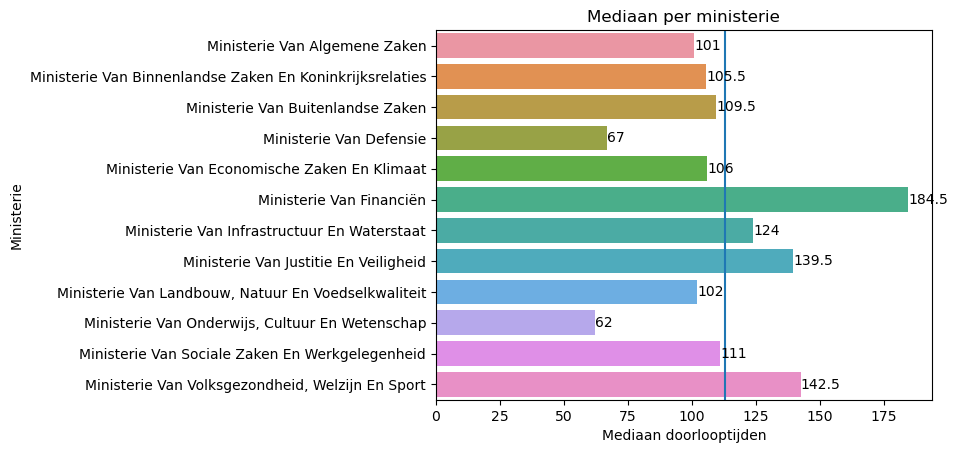

In [42]:
medianen = min2023_cutoff.groupby('dc_publisher_name')['looptijd_foi'].median().reset_index()

median_plot = sns.barplot(medianen, x='looptijd_foi', y='dc_publisher_name', orient='h')
median_plot.axvline(x=medianen['looptijd_foi'].mean())
median_plot.set_title("Mediaan per ministerie")
median_plot.set(ylabel='Ministerie', xlabel='Mediaan doorlooptijden')
median_plot.bar_label(median_plot.containers[0], fontsize=10);

count    1363.00000
mean      178.42113
50%       119.00000
min         0.00000
max      3198.00000
Name: looptijd_foi, dtype: float64

Totale gewogen gemiddelde doorlooptijd: 178.4211298606016


,count,mean,50%,min,max
dc_publisher_name,,,,,
Ministerie Van Algemene Zaken,53.0,133.471698,101.0,0.0,525.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,84.0,147.809524,105.5,0.0,784.0
Ministerie Van Buitenlandse Zaken,58.0,120.862069,109.5,9.0,465.0
Ministerie Van Defensie,44.0,113.863636,67.0,8.0,457.0
Ministerie Van Economische Zaken En Klimaat,110.0,144.345455,106.0,0.0,560.0
Ministerie Van Financiën,200.0,246.665000,184.5,5.0,3198.0
Ministerie Van Infrastructuur En Waterstaat,165.0,211.490909,124.0,3.0,1218.0
Ministerie Van Justitie En Veiligheid,158.0,219.943038,139.5,0.0,1496.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",308.0,170.555195,102.0,0.0,1044.0


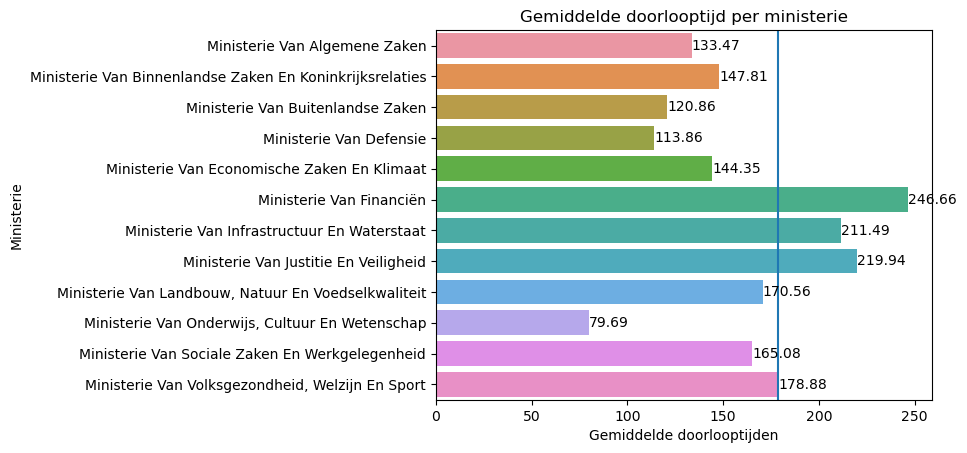

In [43]:
gemiddelden = min2023_cutoff.groupby('dc_publisher_name')['looptijd_foi'].mean().round(2).reset_index()

gemiddelden_plot = sns.barplot(gemiddelden, x='looptijd_foi', y='dc_publisher_name', orient='h')
gemiddelden_plot.axvline(x=min2023_cutoff['looptijd_foi'].mean())
gemiddelden_plot.set_title("Gemiddelde doorlooptijd per ministerie")
gemiddelden_plot.set(ylabel='Ministerie', xlabel='Gemiddelde doorlooptijden')
gemiddelden_plot.bar_label(gemiddelden_plot.containers[0], fontsize=10);

display(min2023_cutoff['looptijd_foi'].describe()[['count', 'mean', '50%', 'min', 'max']])
print(f"Totale gewogen gemiddelde doorlooptijd: {min2023_cutoff['looptijd_foi'].mean()}")
display(min2023_cutoff.groupby('dc_publisher_name')['looptijd_foi'].describe()[['count', 'mean', '50%', 'min', 'max']])

## Paginas dataset niet gefiltered op doorlooptijd outliers

De count ligt hier hoger omdat de outliers niet zijn weggehaald.

count    1450.000000
mean      182.410345
50%        33.000000
min         1.000000
max      8608.000000
Name: foi_documentPages, dtype: float64

Totale gewogen gemiddelde aantal paginas: 182.41034482758621


,count,mean,50%,min,max
dc_publisher_name,,,,,
Ministerie Van Algemene Zaken,54.0,12.277778,3.5,1.0,128.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,88.0,105.102273,19.0,2.0,2097.0
Ministerie Van Buitenlandse Zaken,60.0,139.616667,32.5,2.0,727.0
Ministerie Van Defensie,51.0,106.745098,31.0,1.0,1194.0
Ministerie Van Economische Zaken En Klimaat,115.0,127.226087,50.0,2.0,862.0
Ministerie Van Financiën,207.0,165.420290,27.0,2.0,8608.0
Ministerie Van Infrastructuur En Waterstaat,183.0,267.071038,46.0,2.0,7750.0
Ministerie Van Justitie En Veiligheid,171.0,285.409357,54.0,2.0,7959.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",325.0,159.049231,19.0,2.0,5005.0


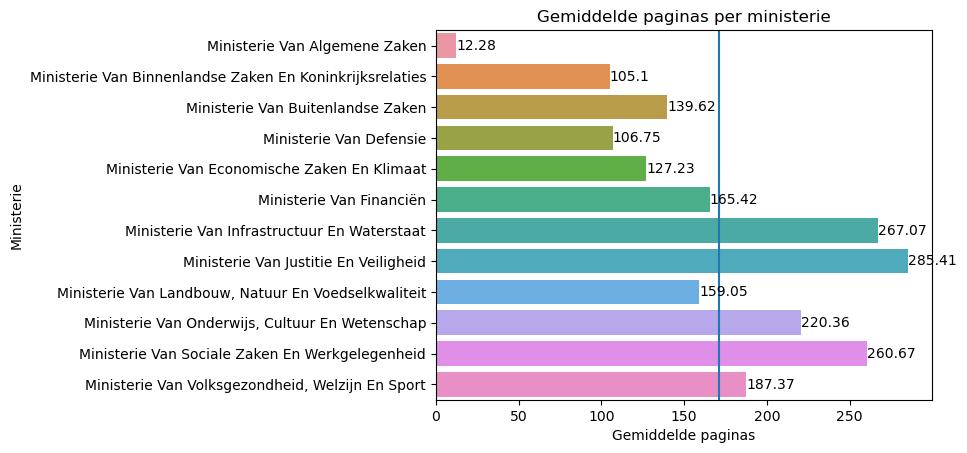

In [44]:
paginas = min2023.groupby(['dc_publisher_name'])['foi_documentPages'].mean().round(2).reset_index()

paginas_plot = sns.barplot(paginas, x='foi_documentPages', y='dc_publisher_name', orient='h')
paginas_plot.axvline(x=min2023_cutoff['foi_documentPages'].mean())
paginas_plot.set_title("Gemiddelde paginas per ministerie")
paginas_plot.set(ylabel='Ministerie', xlabel='Gemiddelde paginas')
paginas_plot.bar_label(paginas_plot.containers[0], fontsize=10);

display(min2023['foi_documentPages'].describe()[['count', 'mean', '50%', 'min', 'max']])
print(f"Totale gewogen gemiddelde aantal paginas: {min2023['foi_documentPages'].mean()}")
display(min2023.groupby('dc_publisher_name')['foi_documentPages'].describe()[['count', 'mean', '50%', 'min', 'max']])